# Genres&ROI

We'll use IMDB and The Numbers data sets to identify which movie genres we can recommend based on analysis

Notes:
- IMDB has a column for genres
- The Numbers has a column for the production budget and worldwide gross
- Combine both using the movie title as an index

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats 
from math import sqrt
%matplotlib inline

## The Numbers *

In [2]:
tn = pd.read_csv('data/tn.movie_budgets.csv')
tn.head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220"
6,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200"
7,8,"May 24, 2007",Pirates of the Caribbean: At Worldâs End,"$300,000,000","$309,420,425","$963,420,425"
8,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209"
9,10,"Nov 6, 2015",Spectre,"$300,000,000","$200,074,175","$879,620,923"


In [3]:
#tn['domestic_gross'] = pd.to_numeric(tn['domestic_gross'])
#tn['domestic_gross'] = tn['domestic_gross'].astype(str).astype(int)
tn[tn.columns[3:]] = (tn[tn.columns[3:]].replace('[\$,]', '', regex=True).astype(float))/1000000
#tn.info()

In [4]:
tn['roi%'] = ((tn.worldwide_gross - tn.production_budget)/tn.production_budget)*100
tn.head(3)
# ROI : Profit earned from investment

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,roi%
0,1,"Dec 18, 2009",Avatar,425.0,760.507625,2776.345279,553.257713
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410.6,241.063875,1045.663875,154.667286
2,3,"Jun 7, 2019",Dark Phoenix,350.0,42.762350,149.762350,-57.210757


In [5]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
q = """SELECT movie, release_date, worldwide_gross
     FROM tn
     ORDER BY worldwide_gross DESC
     LIMIT 10;"""

movies = pysqldf(q)
movies

,movie,release_date,worldwide_gross
0,Avatar,"Dec 18, 2009",2776.345279
1,Titanic,"Dec 19, 1997",2208.208395
2,Star Wars Ep. VII: The Force Awakens,"Dec 18, 2015",2053.311220
3,Avengers: Infinity War,"Apr 27, 2018",2048.134200
4,Jurassic World,"Jun 12, 2015",1648.854864
5,Furious 7,"Apr 3, 2015",1518.722794
6,The Avengers,"May 4, 2012",1517.935897
7,Avengers: Age of Ultron,"May 1, 2015",1403.013963
8,Black Panther,"Feb 16, 2018",1348.258224
9,Harry Potter and the Deathly Hallows: Part II,"Jul 15, 2011",1341.693157


## IMBD (SQL) *

In [6]:
import sqlite3 
conn = sqlite3.connect('data/im.db')
q= """
SELECT original_title AS movie, start_year, genres
FROM movie_basics
"""
im = pd.read_sql(q, conn)
im.head()
#im.info()

,movie,start_year,genres
0,Sunghursh,2013,"Action,Crime,Drama"
1,Ashad Ka Ek Din,2019,"Biography,Drama"
2,The Other Side of the Wind,2018,Drama
3,Sabse Bada Sukh,2018,"Comedy,Drama"
4,La Telenovela Errante,2017,"Comedy,Drama,Fantasy"


In [7]:
#im[im['genres']] = (im['genres']).astype(str)

In [8]:
im=im.dropna()
im.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140734 entries, 0 to 146143
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   movie       140734 non-null  object
 1   start_year  140734 non-null  int64 
 2   genres      140734 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.3+ MB


In [9]:
#pd.read_sql("""
#SELECT *
#FROM movie_basics
#WHERE original_title LIKE '%Avatar%'
#""", conn)

# Merging IMBD with The Numbers

In [10]:
df_combine_genres = pd.merge(tn, im, how = 'inner')
df_combine_genres.sort_values(['worldwide_gross'], ascending=[False], inplace= True)
df_combine_genres.drop_duplicates('movie', keep='first', inplace=True)
df_combine_genres.set_index('movie',  inplace= True)


df_combine_genres.head(10)

,id,release_date,production_budget,domestic_gross,worldwide_gross,roi%,start_year,genres
movie,,,,,,,,
Titanic,43,"Dec 19, 1997",200.0,659.363944,2208.208395,1004.104198,2012,Adventure
Avengers: Infinity War,7,"Apr 27, 2018",300.0,678.815482,2048.134200,582.711400,2018,"Action,Adventure,Sci-Fi"
Jurassic World,34,"Jun 12, 2015",215.0,652.270625,1648.854864,666.909239,2015,"Action,Adventure,Sci-Fi"
The Avengers,27,"May 4, 2012",225.0,623.279547,1517.935897,574.638176,2012,"Action,Adventure,Sci-Fi"
Avengers: Age of Ultron,4,"May 1, 2015",330.6,459.005868,1403.013963,324.384139,2015,"Action,Adventure,Sci-Fi"
Black Panther,42,"Feb 16, 2018",200.0,700.059566,1348.258224,574.129112,2018,"Action,Adventure,Sci-Fi"
Jurassic World: Fallen Kingdom,13,"Jun 22, 2018",170.0,417.719760,1305.772799,668.101646,2018,"Action,Adventure,Sci-Fi"
Frozen,56,"Nov 22, 2013",150.0,400.738009,1272.469910,748.313273,2010,"Adventure,Drama,Sport"
Beauty and the Beast,35,"Mar 17, 2017",160.0,504.014165,1259.199706,686.999816,2018,"Family,Fantasy,Musical"


In [11]:
df_combine_genres.shape

(2253, 8)

## Find every type unique genre

In [12]:
myList = df_combine_genres['genres'].tolist()
#myList
#myList[4].split(',')

In [13]:
genre_list=[]
for i in range(len(myList)):
    genre_list.append(myList[i].split(','))
#genre_list

In [14]:
from itertools import chain
genres=list(set(chain(*genre_list)))
print(genres)
print(len(genres))
print(type(genres))

['Sport', 'War', 'Comedy', 'Adventure', 'Fantasy', 'Music', 'Mystery', 'Horror', 'Western', 'Thriller', 'Action', 'Animation', 'History', 'Documentary', 'News', 'Sci-Fi', 'Family', 'Biography', 'Musical', 'Crime', 'Drama', 'Romance']
22
<class 'list'>


In [15]:
#df_combine_genres.str.contains('Sci-Fi', case=True)
#'Sci-Fi' in df_combine_genres.index

### Data Analysis

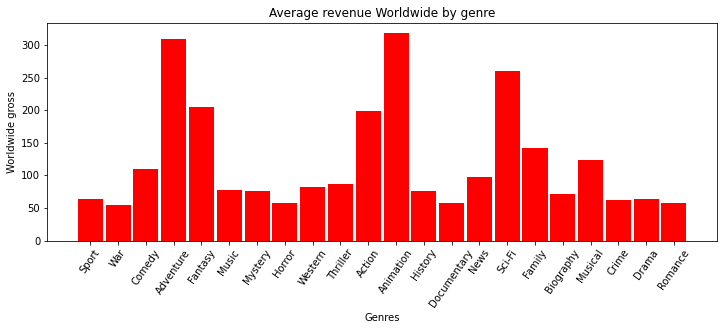

In [16]:
#sns.barplot(x=genres,y=Gsums)
#sns.histplot(df_combine_genres, kde=True)

#Worldwide gross Average profits.
wwg_avg=[] 
for i in range(len(genres)):
    wwg = df_combine_genres['genres'].astype(str).str.contains(genres[i], regex = True, na = False)
    wwg_avg.append(df_combine_genres['worldwide_gross'][wwg].mean())
#wwg_avg

fig = plt.figure(figsize = (12, 4))
 
# creating the bar plot
plt.bar(genres, wwg_avg, color = 'red',width = 0.9)
 
plt.xlabel("Genres")
plt.xticks(rotation = 55)
plt.ylabel("Worldwide gross")
plt.title("Average revenue Worldwide by genre")
plt.show()

#####  Conclusions:
It seems that the movie genres that generate the most money worldwide are Animation, Adventure, Sci-fi, Fantasy and Action, respectively in that order being like the top 5.

There may be different reasons why this happens and we could do more exploratory analysis or perhaps this question is out of our scope.

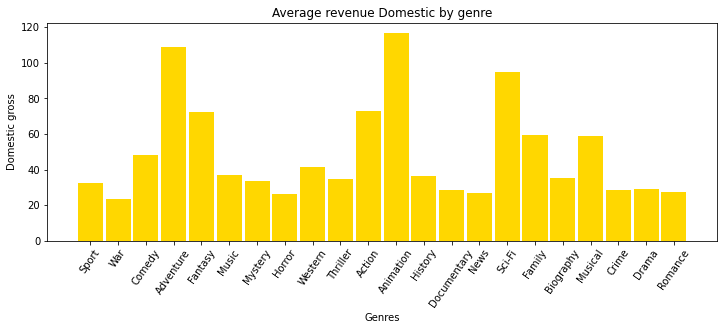

In [17]:
#Domestic gross Average profits.
dg_avg=[]
for i in range(len(genres)):
    dg = df_combine_genres['genres'].astype(str).str.contains(genres[i], regex = True, na = False)
    dg_avg.append(df_combine_genres['domestic_gross'][dg].mean())
#dg_avg


fig = plt.figure(figsize = (12, 4))
plt.bar(genres, dg_avg, color='gold' ,width = 0.9)
 
plt.xlabel("Genres")
plt.xticks(rotation = 55)
plt.ylabel("Domestic gross")
plt.title("Average revenue Domestic by genre")
plt.show()

#####  Conclusions:
By country of origin earnings are similar for each genre. Animation, Adventure, Science Fiction, Fantasy and Action as the top 5.

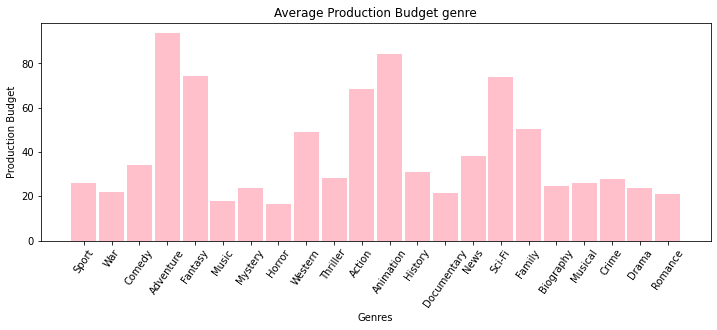

In [18]:
#production_budget Average profits.
pb_avg=[]
for i in range(len(genres)):
    pb = df_combine_genres['genres'].astype(str).str.contains(genres[i], regex = True, na = False)
    pb_avg.append(df_combine_genres['production_budget'][pb].mean())
#print(pb_avg)


fig = plt.figure(figsize = (12, 4))
plt.bar(genres, pb_avg, color='pink' ,width = 0.9)
 
plt.xlabel("Genres")
plt.xticks(rotation = 55)
plt.ylabel("Production Budget")
plt.title("Average Production Budget genre")
plt.show()

#####  Conclusions:
On the other hand we have that the most expensive films to produce are precisely Adventure, Animation, Fantasy, Sci-Fi and Action in that order, given the equipment and technology that is needed to create these films such as visual effects, computers or tools and labor in order to Make the movie.

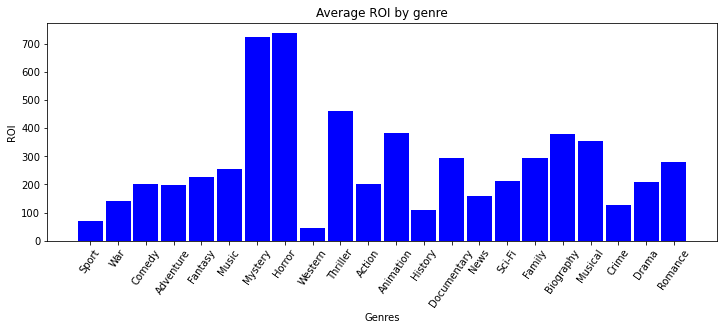

In [19]:
#Roi Average profits.
roi_avg=[]
for i in range(len(genres)):
    roi = df_combine_genres['genres'].astype(str).str.contains(genres[i], regex = True, na = False)
    roi_avg.append(df_combine_genres['roi%'][roi].mean())
#print(roi_avg)


fig = plt.figure(figsize = (12, 4))
plt.bar(genres, roi_avg, color='blue' ,width = 0.9)

plt.xlabel("Genres")
plt.xticks(rotation = 55)
plt.ylabel("ROI")
plt.title("Average ROI by genre")
plt.show()

#####  Conclusions:
Regarding the ROI we can clearly see that the genres that stands out the most are Horror and Mystery especially, then Thriller, Animation and Biography in that order without much difference.

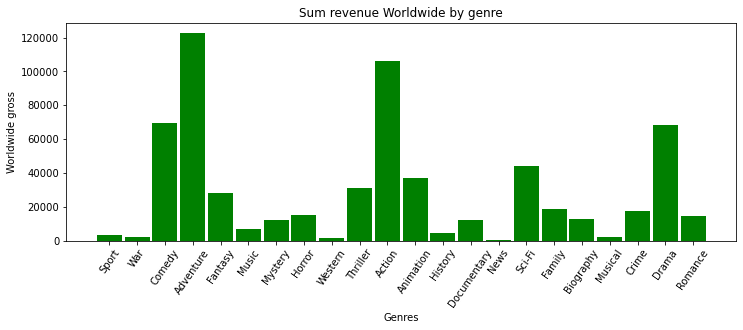

In [20]:
#Worldwide gross sum profits.
wwg_sum=[]
for i in range(len(genres)):
    Gsum = df_combine_genres['genres'].astype(str).str.contains(genres[i], regex = True, na = False)
    wwg_sum.append(df_combine_genres['worldwide_gross'][Gsum].sum())
#wwg_sum

fig = plt.figure(figsize = (12, 4))
 
# creating the bar plot
plt.bar(genres, wwg_sum, color = 'green', width = 0.9)
 
plt.xlabel("Genres")
plt.xticks(rotation = 55)
plt.ylabel("Worldwide gross")
plt.title("Sum revenue Worldwide by genre")
plt.show()

In [21]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

q = """SELECT movie, worldwide_gross, genres
     FROM df_combine_genres
     WHERE genres LIKE '%Sci-Fi%'
     ;"""
gen = pysqldf(q)
gen

,movie,worldwide_gross,genres
0,Avengers: Infinity War,2048.134200,"Action,Adventure,Sci-Fi"
1,Jurassic World,1648.854864,"Action,Adventure,Sci-Fi"
2,The Avengers,1517.935897,"Action,Adventure,Sci-Fi"
3,Avengers: Age of Ultron,1403.013963,"Action,Adventure,Sci-Fi"
4,Black Panther,1348.258224,"Action,Adventure,Sci-Fi"
...,...,...,...
165,Womb,0.000000,"Drama,Romance,Sci-Fi"
166,The Dead Undead,0.000000,"Action,Horror,Sci-Fi"
167,Infected,0.000000,"Action,Horror,Sci-Fi"
168,Mutant World,0.000000,Sci-Fi


In [22]:
from pandasql import sqldf                   #sum of every movie that is at least Sci-fi
pysqldf = lambda f: sqldf(f, globals())
f = """
     SELECT SUM(worldwide_gross) SciFi 
     FROM df_combine_genres
     WHERE genres LIKE '%Sci-Fi%'
     ;"""

Ugen = pysqldf(f)
Ugen

,SciFi
0,44201.874781


# Hypothesis Testing

Our team wanted to see if musicals generete a larger ROI than other genres.

### State our Hypotheses:
H-Alt -> The average ROI for Horror is higher than other movies  $$\large H_a\text{:   }\mu < \bar{x}$$

H-Null -> There is no difference in the ROI for Horror vs. other movies  $$\large H_o\text{:   }\mu \geq \bar{x}$$

Alpha: 0.05

In [23]:
df_combine_genres.describe()

,id,production_budget,domestic_gross,worldwide_gross,roi%,start_year
count,2253.000000,2253.000000,2253.000000,2253.000000,2253.000000,2253.000000
mean,50.611185,35.736747,44.354681,107.044173,279.470740,2014.051931
std,28.600136,48.988185,74.345932,202.446899,1462.669293,2.663893
min,1.000000,0.001400,0.000000,0.000000,-100.000000,2010.000000
25%,26.000000,5.000000,0.582024,2.436111,-62.746792,2012.000000
50%,50.000000,18.000000,17.742948,30.535660,66.974493,2014.000000
75%,75.000000,42.500000,54.333290,109.501146,263.120550,2016.000000
max,100.000000,410.600000,700.059566,2208.208395,41556.474000,2021.000000


In [24]:
#population mean and std

roi_mean = df_combine_genres['roi%'].mean()
roi_std = df_combine_genres['roi%'].std()

stats.norm(roi_mean, roi_std)
plt.style.use('seaborn')

In [25]:
df_horror = df_combine_genres[df_combine_genres['genres'].str.contains('Horror')]
df_horror.head()

,id,release_date,production_budget,domestic_gross,worldwide_gross,roi%,start_year,genres
movie,,,,,,,,
It,24,"Sep 8, 2017",35.0,327.481748,697.457969,1892.737054,2017,"Horror,Thriller"
The Revenant,27,"Dec 25, 2015",135.0,183.637894,532.938302,294.769113,2012,Horror
World War Z,69,"Jun 21, 2013",190.0,202.359711,531.514650,179.744553,2013,"Action,Adventure,Horror"
The Meg,94,"Aug 10, 2018",178.0,145.443742,529.530715,197.489166,2018,"Action,Horror,Sci-Fi"
Ghost,5,"Jul 13, 1990",22.0,217.631306,517.600000,2252.727273,2012,Horror


In [26]:
horror_mean = df_horror['roi%'].mean()
horror_std = df_horror['roi%'].std()
print(horror_mean)
print(horror_std)

738.5423707586857
3178.5944785355246


In [27]:
# z score

x_bar= horror_mean
n =  len(df_horror.id)
sigma = roi_std
mu = roi_mean
z = (x_bar - mu)/(sigma/sqrt(n))
z

pval= 1-stats.norm.cdf(z)
print(pval, z)
print(stats.norm.cdf(z))

1.2531737481058514e-07 5.157226353535224
0.9999998746826252


In [28]:
pval < 0.05

True

The percent area under the curve from to a  𝑧 score of 5.157 is 99.9% this means that the ROI average for horror movies is bigger than 99.9%.

Due to our p- value < 0.05 we know that there is enough evidence to reject the null hypothesis with the given sample in other words ROI average for horror movies are significantly higher than the population. 

## Mystery sample

In [29]:
df_mystery = df_combine_genres[df_combine_genres['genres'].str.contains('Mystery')]
df_mystery

,id,release_date,production_budget,domestic_gross,worldwide_gross,roi%,start_year,genres
movie,,,,,,,,
The Hangover Part II,39,"May 26, 2011",80.0,254.464305,586.464305,633.080381,2011,"Comedy,Mystery"
Prometheus,75,"Jun 8, 2012",125.0,126.477084,402.448265,221.958612,2012,"Adventure,Mystery,Sci-Fi"
Gone Girl,36,"Oct 3, 2014",61.0,167.767189,368.567189,504.208507,2014,"Drama,Mystery,Thriller"
The Maze Runner,60,"Sep 19, 2014",34.0,102.427862,348.319861,924.470179,2014,"Action,Mystery,Sci-Fi"
Murder on the Orient Express,95,"Nov 10, 2017",55.0,102.826543,345.922730,528.950418,2017,"Crime,Drama,Mystery"
...,...,...,...,...,...,...,...,...
The Curse of Downers Grove,98,"Aug 21, 2015",2.0,0.000000,0.000000,-100.000000,2015,"Drama,Horror,Mystery"
Sharkskin,86,"Jan 19, 2016",2.1,0.000000,0.000000,-100.000000,2015,"Comedy,Drama,Mystery"
Deadline,29,"Dec 31, 2009",1.8,0.000000,0.000000,-100.000000,2012,"Drama,Mystery,Thriller"


In [30]:
mystery_mean = df_mystery['roi%'].mean()
print(mystery_mean)

727.1498822842362


In [31]:
x_bar= mystery_mean
n =  len(df_mystery.id)
sigma = roi_std
mu = roi_mean
z = (x_bar - mu)/(sigma/sqrt(n))
z

pval= 1-stats.norm.cdf(z)
print(pval, z)
print(stats.norm.cdf(z))

5.1462173844107895e-05 3.8835925063207046
0.9999485378261559


In [32]:
pval < 0.05

True

## Thriller sample

In [33]:
df_Thriller = df_combine_genres[df_combine_genres['genres'].str.contains('Thriller')]
df_Thriller

,id,release_date,production_budget,domestic_gross,worldwide_gross,roi%,start_year,genres
movie,,,,,,,,
The Fate of the Furious,23,"Apr 14, 2017",250.0000,225.764765,1234.846267,393.938507,2017,"Action,Crime,Thriller"
Skyfall,52,"Nov 8, 2012",200.0000,304.360277,1110.526981,455.263490,2012,"Action,Adventure,Thriller"
The Dark Knight Rises,11,"Jul 20, 2012",275.0000,448.139099,1084.439099,294.341491,2012,"Action,Thriller"
Spectre,10,"Nov 6, 2015",300.0000,200.074175,879.620923,193.206974,2015,"Action,Adventure,Thriller"
Venom,3,"Oct 5, 2018",116.0000,213.511408,853.628605,635.886728,2018,"Action,Sci-Fi,Thriller"
...,...,...,...,...,...,...,...,...
Pendulum,93,"Dec 31, 2001",2.0000,0.000000,0.000000,-100.000000,2017,Thriller
Deadline,29,"Dec 31, 2009",1.8000,0.000000,0.000000,-100.000000,2012,"Drama,Mystery,Thriller"
Girlhouse,14,"Feb 13, 2015",1.5000,0.000000,0.000000,-100.000000,2014,"Horror,Thriller"


In [34]:
Thriller_mean = df_Thriller['roi%'].mean()
print(Thriller_mean)

460.52755409613025


In [35]:
x_bar= Thriller_mean
n =  len(df_Thriller.id)
sigma = roi_std
mu = roi_mean
z = (x_bar - mu)/(sigma/sqrt(n))
z

pval= 1-stats.norm.cdf(z)
print(pval, z)
print(stats.norm.cdf(z))

0.009257014873816805 2.355174088459677
0.9907429851261832


In [36]:
pval < 0.05

True

## Animation sample:

In [37]:
df_Animation = df_combine_genres[df_combine_genres['genres'].str.contains('Animation')]
df_Animation

,id,release_date,production_budget,domestic_gross,worldwide_gross,roi%,start_year,genres
movie,,,,,,,,
Incredibles 2,44,"Jun 15, 2018",200.0,608.581744,1242.520711,521.260355,2018,"Action,Adventure,Animation"
Minions,73,"Jul 10, 2015",74.0,336.045770,1160.336173,1468.021855,2015,"Adventure,Animation,Comedy"
Toy Story 3,47,"Jun 18, 2010",200.0,415.004880,1068.879522,434.439761,2010,"Adventure,Animation,Comedy"
Despicable Me 3,30,"Jun 30, 2017",75.0,264.624300,1034.727750,1279.637000,2017,"Adventure,Animation,Comedy"
Finding Dory,46,"Jun 17, 2016",200.0,486.295561,1021.215193,410.607596,2016,"Adventure,Animation,Comedy"
...,...,...,...,...,...,...,...,...
O Menino e o Mundo,54,"Dec 11, 2015",0.5,0.129479,0.280967,-43.806600,2013,"Adventure,Animation,Family"
Foodfight!,26,"Dec 31, 2012",45.0,0.000000,0.073706,-99.836209,2012,"Action,Animation,Comedy"
Dwegons and Leprechauns,14,"Aug 29, 2014",20.0,0.000000,0.000000,-100.000000,2014,Animation


In [38]:
Animation_mean = df_Animation['roi%'].mean()
print(Animation_mean)

383.76224077807365


In [39]:
x_bar= Animation_mean
n =  len(df_Animation.id)
sigma = roi_std
mu = roi_mean
z = (x_bar - mu)/(sigma/sqrt(n))
z

pval= 1-stats.norm.cdf(z)
print(pval, z)
print(stats.norm.cdf(z))

0.22027910487726254 0.771250933083705
0.7797208951227375


In [40]:
pval < 0.05

False